In [1]:
# pip install arff pandas numpy spacy seaborn matplotlib sklearn openpyxl
# python3 -m spacy download pt_core_news_sm

In [2]:
# Fazendo imports
import arff
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from spacy.lang.pt.stop_words import STOP_WORDS
from spacy.lang.pt import Portuguese

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV

In [4]:
# Criando dataset de treino e de teste
train_data = pd.read_csv("df_dataset.csv")

test_data = pd.read_csv("df_dataset_test.csv")

In [6]:
# Word tokenization
import spacy
import string

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('pt_core_news_sm')
stop_words = spacy.lang.pt.stop_words.STOP_WORDS

# Creating our tokenizer function
def spacy_tokenizer(sentence, lemmatize=False, remove_stop_words=False, remove_punctuations=False):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = nlp(sentence)

    # Lematizando os tokens e colocando em caixa baixa
    if (lemmatize):
        mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    else:
        mytokens = [ word.text.lower().strip() for word in mytokens ]

    # Removendo stop words
    if (remove_stop_words):
        mytokens = [ word for word in mytokens if word not in stop_words ]        
        
    if (remove_punctuations):
        mytokens = [ word for word in mytokens if word not in punctuations ]
        
    # Retornando a lista de token reprocessado
    return mytokens

text_pipeline = lambda x: spacy_tokenizer(x, lemmatize=True, remove_stop_words=True)
label_pipeline = lambda x: int(x)

In [7]:
# Tokenizando, transformando para lemas e botando em caixa baixa cada tweet
train_data['txt_tokenized'] = [text_pipeline(str(txt)) for txt in train_data.txt]
test_data['txt_tokenized'] = [text_pipeline(str(txt)) for txt in test_data.txt]

train_data.head()

,Unnamed: 0,docno,has_anger,origin,txt,txt_tokenized
0,0,23310,1,55chan/pol,apóio o . um passo de cada vez. não tenha pres...,"[apóio, ., passar, ., pressa, ,, mover, pra, f..."
1,1,1141756984838054016,0,twitter,eu ainda vou surtar com essa fic,"[surtar, fic]"
2,10,1141783320881241984,0,twitter,NOMEPROPRIO queijo,"[nomeproprio, queijar]"
3,1000,1137392542050393984,0,twitter,hoje eu só tô minha irmã ali kkkkkkkkkkkkkk,"[hoje, tô, irmão, kkkkkkkkkkkkkk]"
4,1001,58451,1,55chan/pol,ela me chamou pra dormir na casa dela pois est...,"[chamar, pra, dormir, casar, dela, "", medo, "",..."


In [8]:
# Juntando os tokens de volta em um única string
train_data.txt_tokenized = train_data.apply(lambda x: " ".join(x.txt_tokenized), axis=1)
test_data.txt_tokenized = test_data.apply(lambda x: " ".join(x.txt_tokenized), axis=1)

train_data.head()

,Unnamed: 0,docno,has_anger,origin,txt,txt_tokenized
0,0,23310,1,55chan/pol,apóio o . um passo de cada vez. não tenha pres...,"apóio . passar . pressa , mover pra frente . m..."
1,1,1141756984838054016,0,twitter,eu ainda vou surtar com essa fic,surtar fic
2,10,1141783320881241984,0,twitter,NOMEPROPRIO queijo,nomeproprio queijar
3,1000,1137392542050393984,0,twitter,hoje eu só tô minha irmã ali kkkkkkkkkkkkkk,hoje tô irmão kkkkkkkkkkkkkk
4,1001,58451,1,55chan/pol,ela me chamou pra dormir na casa dela pois est...,"chamar pra dormir casar dela "" medo "" barulho ..."


In [9]:
# Separando o treino e o teste em dois conjuntos diferentes
x_train=train_data.txt_tokenized
y_train=train_data.has_anger
x_test=test_data.txt_tokenized
y_test=test_data.has_anger

In [10]:
# convertendo em BOW com valoração de frequência
freq_vector = CountVectorizer(min_df=5, ngram_range=(1,2)).fit(train_data.txt_tokenized)

x_train = freq_vector.transform(x_train)
x_test = freq_vector.transform(x_test)

In [11]:
x_train.shape

(7251, 8852)

In [12]:
x_test.shape

(421, 8852)

In [13]:
# # Logistic Regression Classifier sem Cross Validation
# from sklearn.linear_model import LogisticRegression
# classifier = LogisticRegression(max_iter=500)

# # model generation
# classifier.fit(x_train, y_train)

In [14]:
# Logistic Regression Classifier com Cross Validation

from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
kfold = KFold()
classifier = LogisticRegressionCV(max_iter=500, cv=kfold)

# model generation
classifier.fit(x_train, y_train)

LogisticRegressionCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
                     max_iter=500)

In [15]:
# Resultados do dataset de treino

from sklearn.metrics import precision_recall_fscore_support
y_pred_train=classifier.predict(x_train)
precision_recall_fscore_support(y_train, y_pred_train, average='macro')

(0.999724175844575, 0.999724175844575, 0.999724175844575, None)

In [16]:
# Resultados do dataset de teste

y_pred = classifier.predict(x_test)
precision_recall_fscore_support(y_test, y_pred, average='macro')

(0.9584464043419267, 0.9575771939328277, 0.9572328321820398, None)

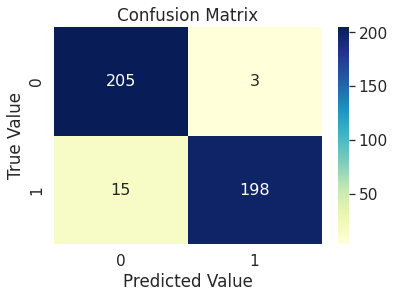

In [17]:
# Plotando matriz de confusão

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

def plot_cm(conf_matrix):
  sns.set(font_scale=1.4,color_codes=True,palette="deep")
  sns.heatmap(cm,annot=True,annot_kws={"size":16},fmt="d",cmap="YlGnBu")
  plt.title("Confusion Matrix")
  plt.xlabel("Predicted Value")
  plt.ylabel("True Value")

plot_cm(cm)

In [18]:
print(cross_val_score(LogisticRegressionCV(random_state=42), x_train, y_train, cv=10, verbose=1, n_jobs=-1, scoring='recall').mean())
print(cross_val_score(LogisticRegressionCV(random_state=42), x_train, y_train, cv=10, verbose=1, n_jobs=-1, scoring='accuracy').mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.


0.950040333013713


/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

0.9663490073145246


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   12.0s finished


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:35

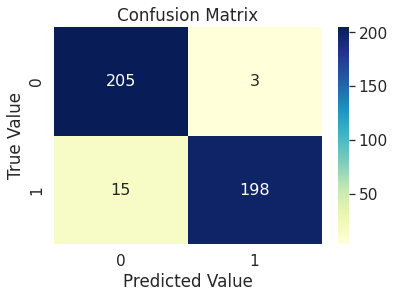

In [19]:
params = {
    'solver':['liblinear','saga','newton-cg','lbfgs'],
#     'C':[0.001,0.01,0.1,1,10,100],
#     'penalty':['l1','l2']
}

lr_grid = GridSearchCV(LogisticRegressionCV(random_state=42),params, cv=5, verbose=2, n_jobs=-1)
lr_grid.fit(x_train, y_train)

y_predict=lr_grid.predict(x_test)
cm=confusion_matrix(y_test, y_predict)
plot_cm(cm)

In [20]:
# TESTE
x_try = freq_vector.transform(['texto aqui'])

print(x_try)

y_try = classifier.predict(x_try)

print(y_try)

precision_recall_fscore_support(y_try, [1.0], average='macro')

  (0, 656)	1
  (0, 7935)	1
[0]


/home/arthurn/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(0.0, 0.0, 0.0, None)

[CV] END ...................................solver=liblinear; total time=   5.3s
[CV] END ...................................solver=newton-cg; total time=   3.3s
[CV] END ...................................solver=newton-cg; total time=   3.4s
[CV] END ...................................solver=newton-cg; total time=   3.0s
[CV] END ...................................solver=newton-cg; total time=   4.7s


/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

[CV] END ...................................solver=liblinear; total time=   5.1s
[CV] END ........................................solver=saga; total time=  11.0s
[CV] END .......................................solver=lbfgs; total time=   4.8s


/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:35

[CV] END ...................................solver=liblinear; total time=   4.9s
[CV] END ........................................solver=saga; total time=  10.9s
[CV] END .......................................solver=lbfgs; total time=   5.7s
[CV] END ........................................solver=saga; total time=  12.4s
[CV] END ...................................solver=newton-cg; total time=   3.5s
[CV] END .......................................solver=lbfgs; total time=   5.7s
[CV] END ...................................solver=liblinear; total time=   5.2s
[CV] END ........................................solver=saga; total time=  10.9s
[CV] END .......................................solver=lbfgs; total time=   5.6s


/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:35

/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/arthurn/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

[CV] END ...................................solver=liblinear; total time=   5.3s
[CV] END ........................................solver=saga; total time=  10.8s
[CV] END .......................................solver=lbfgs; total time=   5.6s
